**Table of Contents:**
- [Libraries](#lib)
- [Functions & Constants](#fun)
- [Load Data: Marketing Campaign Data](#data1)
- [Standard Deviation Method](#std)
- [Robust Z-Score](#z)
- [Inter-Quartile Range](#iqr)
- [Load Data: Housing Prices Data](#data2)
- [Isolation Forest](#iso)
- [Elliptic Envelope](#ell)
- [DBSCAN](#dbscan)
- [Local Outlier Factor](#local)

<a id="lib"> </a>

## Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arketing-campaign/marketing_campaign.csv
/kaggle/input/arketing-campaign/marketing_campaign.xlsx
/kaggle/input/melbourne-housing-snapshot/melb_data.csv


In [2]:
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import normaltest, median_abs_deviation
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor

<a id="fun"> </a>

## Functions & Constants

In [3]:
# Outlier Detection using Standard Deviation:
def outlier_std(df,var_of_interest, nstd=3.0):
    """
    An Outlier is a Value that is Less Than Mean- nstd* Standard Deviation 
    or Greater Than Mean + nstd* Standard Deviation
    """
    data_mean, data_std = df[var_of_interest].mean(), df[var_of_interest].std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    df[f"out_std_{var_of_interest}"]= np.where(
        (df[var_of_interest]<lower) | (df[var_of_interest] > upper),1,0)


# Outlier Detection using Inter-Quartile Range
def outlier_iqr(df,var_of_interest, k=1.5):
    """
    An Outlier is a Value that is Less Q1- (1.5 * (Q3 - Q1) )
    or Greater Than Q3 + (1.5 * (Q3 - Q1) )
    """
    global lower, upper
    # calculate interquartile range
    q25, q75 = np.percentile(df[var_of_interest], 25), np.percentile(df[var_of_interest], 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    df[f"out_iqr_{var_of_interest}"]= np.where(
        (df[var_of_interest]<lower) | (df[var_of_interest] > upper),1,0)
    
    
# Winsorization Method(Percentile Capping):
def outlier_winsor(df, var_of_interest):
    """
    An Outlier is a value that is either greater than the 99th percentile
    or is below the 1st percentile
    """
    global lower, upper
    lower = np.percentile(df[var_of_interest] , 1)
    upper = np.percentile(df[var_of_interest] , 99)
    df[f"out_win_{var_of_interest}"]= np.where(
        (df[var_of_interest]< lower) | (df[var_of_interest] > upper),1,0)
    
# Using Z-Score: Results same as outlier_std
def z_score(df, var_of_interest,threshold=3):
    mean, std = np.mean(df[var_of_interest]), np.std(df[var_of_interest])
    z_score = np.abs((df[var_of_interest] - mean) / std)
    #if z_score > threshold
    df[f"out_z_{var_of_interest}"] = np.where(z_score > threshold,1,0)
    
    
def zr_score(df, var_of_interest,threshold=3):
    """
    Since Mean itself is affected by Outliers, an interesting modification to Z-Score is
    Robust Z-Score which uses Median instead of Mean
    """
    med = np.median(df[var_of_interest])
    ma = median_abs_deviation(df[var_of_interest])
    z_score = (0.6745 * (df[var_of_interest] - med)) / (np.median(ma))
    #if z_score > threshold
    df[f"out_zr_{var_of_interest}"] = np.where(np.abs(z_score) > threshold,1,0)

<a id="data1"> </a>

## Load Data

In [4]:
df= pd.read_csv("../input/arketing-campaign/marketing_campaign.csv", delimiter=";")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## Checking Null values

In [5]:
print(len(df))
print(df.isna().sum())

#Now remove all rows with NULL values
df.dropna(axis=0,inplace=True)

print(len(df))

2240
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64
2216


### Checking Normality

In [6]:
num_cols= [c for c in df.columns if (df[c].dtypes =="int64") | (df[c].dtypes =="float64")]

for c in num_cols:
    k2, p = normaltest(df[c])
    print (c, "   -----   ", p)

ID    -----    0.0
Year_Birth    -----    2.1317039828739932e-16
Income    -----    0.0
Kidhome    -----    6.839208088925534e-67
Teenhome    -----    1.2722904566026592e-114
Recency    -----    0.0
MntWines    -----    2.6464559710369372e-77
MntFruits    -----    5.47657698185074e-198
MntMeatProducts    -----    8.775966996254418e-201
MntFishProducts    -----    7.897721258885123e-173
MntSweetProducts    -----    1.2812910287612366e-198
MntGoldProds    -----    2.6691458157024386e-167
NumDealsPurchases    -----    1.0508519178382418e-257
NumWebPurchases    -----    2.9111976622543176e-121
NumCatalogPurchases    -----    6.080754627972731e-210
NumStorePurchases    -----    6.309079973163474e-51
NumWebVisitsMonth    -----    1.8053861268655265e-25
AcceptedCmp3    -----    0.0
AcceptedCmp4    -----    0.0
AcceptedCmp5    -----    0.0
AcceptedCmp1    -----    0.0
AcceptedCmp2    -----    0.0
Complain    -----    0.0
Z_CostContact    -----    0.0
Z_Revenue    -----    0.0
Response    -----

<a id="std"> </a>

## Univariate Methods: Parametric

### 1. Standard Deviation

An Outlier is a Value that is Less Than Mean- nstd* Standard Deviation or Greater Than Mean + nstd* Standard Deviation

In [7]:
for c in ["Year_Birth","Income"]:
    outlier_std(df,c)
    fig= px.histogram(data_frame= df, x= c, color= f"out_std_{c}" )
    fig.show()

<a id="z"> </a>

### 2. Robust Z-Score

Z-Score method will give the same results as the underlying concept is the same. However, since Mean itself is affected by Outliers, an interesting modification will be to use Robust Z-Score which uses Median instead of Mean

In [8]:
zr_score(df,"Income")
fig= px.histogram(data_frame= df, x= c, color= f"out_zr_Income" )
fig.show()

<a id="iqr"> </a>

### Univariate: 3. Inter-Quartile Range

An Outlier is a Value that is Less Q1- (1.5 * (Q3 - Q1) ) or Greater Than Q3 + (1.5 * (Q3 - Q1) )

In [9]:
outlier_iqr(df,"Income")
fig= px.histogram(data_frame= df, x= c, color= "out_iqr_Income" )
fig.show()

### Some more Visualisations to plot Outlier data points

In [10]:
#Boxplot: Use Inter-Quartile Concept
fig= px.box(df, x="Income")
fig.show()

<Figure size 720x432 with 0 Axes>

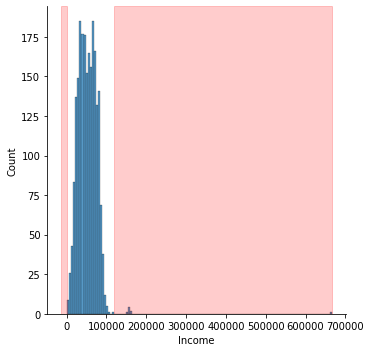

In [11]:
#Red portion contains Outliers
plt.figure(figsize = (10,6))
sns.displot(df["Income"], kde=False)
plt.axvspan(xmin = lower,xmax= df["Income"].min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df["Income"].max(),alpha=0.2, color='red')

<a id="data2"> </a>

## Multivariate Methods

Let us use Housing Price dataset

In [12]:
hdf= pd.read_csv("../input/melbourne-housing-snapshot/melb_data.csv")

In [13]:
print (len(hdf))
print(hdf.isna().sum())

#Remove columns that have >10% Missing data
hdf.drop(["CouncilArea"],axis= 1,inplace=True)

#Now remove all rows with NULL values
#hdf.dropna(axis=0,inplace=True)

hdf.fillna(hdf.median(), inplace = True)

print (len(hdf))

13580
Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64
13580


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [14]:
for c in ["Price","Distance","Landsize"]:
    fig= px.histogram(data_frame= hdf, x= c)
    fig.show()

<a id="iso"> </a>

### 1. Isolation Forest

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

**Parameters:**
- contamination: The proportion of outliers in the data set. If ‘auto’, the threshold is determined as in the original paper. If float, the contamination should be in the range (0, 0.5].
- max_features: The number of features to draw from X to train each base estimator. If int, then draw max_features features. If float, then draw max_features * X.shape[1] features. Default: 1.0

In [15]:
hcols=["Price","Distance","Landsize"]

In [16]:
iso = IsolationForest(n_estimators=100, contamination = "auto" ,max_features = 1.0 )
iso.fit(hdf[hcols])
hdf["outliers_iso"]=iso.predict(hdf[hcols])

hdf["outliers_iso"].value_counts()

 1    12061
-1     1519
Name: outliers_iso, dtype: int64

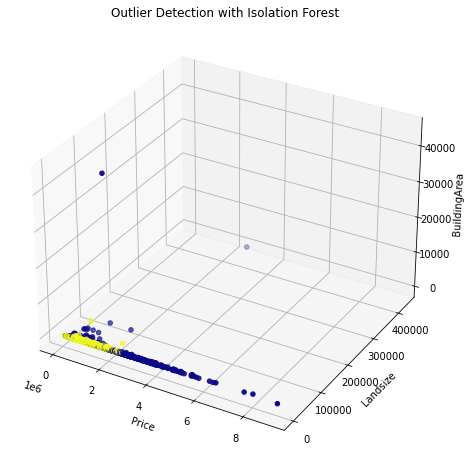

In [17]:
#A 3D Projection Of Data 
x =hdf["Price"]
y =hdf["Landsize"]
z =hdf["BuildingArea"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c= hdf["outliers_iso"], marker="o" , cmap="plasma")
ax.set_title("Outlier Detection with Isolation Forest")
ax.set_xlabel("Price")
ax.set_ylabel("Landsize")
ax.set_zlabel("BuildingArea")
plt.show()

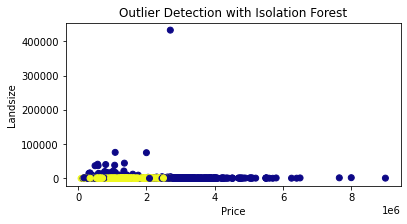

In [18]:
#A 2D Projection Of Data 
x =hdf["Price"]
y =hdf["Landsize"]

plt.figure(figsize=(6,3))
plt.scatter(x,y, c= hdf["outliers_iso"], marker="o" , cmap="plasma")
plt.title("Outlier Detection with Isolation Forest")
plt.xlabel("Price")
plt.ylabel("Landsize")
plt.show()

<a id="ell"> </a>

### 2. Elliptic Envelope

This algorithm creates an imaginary elliptical area around a given dataset. Values that fall inside the envelope are considered normal data and anything outside the envelope is returned as outliers.It works best with Gaussian distributed data.

In [19]:
# Method 1: Using Labels
el = EllipticEnvelope(contamination=0.1)
el.fit(hdf[hcols])

hdf["outliers_ellip_cont"] = el.predict(hdf[hcols])

hdf["outliers_ellip_cont"].value_counts()

 1    12222
-1     1358
Name: outliers_ellip_cont, dtype: int64

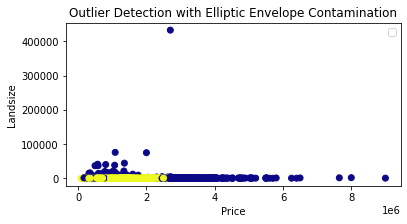

In [20]:
#A 2D Projection Of Data 
x =hdf["Price"]
y =hdf["Landsize"]

plt.figure(figsize=(6,3))
plt.scatter(x,y, c= hdf["outliers_ellip_cont"], marker="o" , cmap="plasma")
plt.title("Outlier Detection with Elliptic Envelope Contamination")
plt.xlabel("Price")
plt.ylabel("Landsize")
plt.legend()
plt.show()

In [21]:
# Method 2: Using Score
elenv = EllipticEnvelope()

elenv.fit(hdf[hcols])
hdf["ellip_score"] = elenv.score_samples(hdf[hcols]) 

#Let us obtain the threshold value from the scores by using the quantile function. 
#Here, we'll get the lowest 2 percent of score values as the anomalies.

hdf["ellip_thresh"] = hdf["ellip_score"].quantile(.02)

hdf["outliers_ellip_score"] = np.where(hdf["ellip_score"] < hdf["ellip_thresh"], -1,0)
hdf.head()
print(hdf["outliers_ellip_score"].value_counts())

 0    13308
-1      272
Name: outliers_ellip_score, dtype: int64


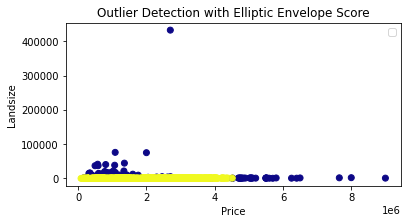

In [22]:
#A 2D Projection Of Data 
x =hdf["Price"]
y =hdf["Landsize"]

plt.figure(figsize=(6,3))
plt.scatter(x,y, c= hdf["outliers_ellip_score"], marker="o" , cmap="plasma")
plt.title("Outlier Detection with Elliptic Envelope Score")
plt.xlabel("Price")
plt.ylabel("Landsize")
plt.legend()
plt.show()

<a id= "dbscan"> </a>

## Non-Parametric Methods: Multivariate

### 1. DBSCAN

DBSCAN is a density-based and unsupervised machine learning algorithm. It takes multi-dimensional data as inputs and clusters them according to the model parameters — e.g. epsilon and minimum samples. It groups ‘densely grouped’ data points into a single cluster. It can identify clusters in large spatial datasets by looking at the local density of the data points. 
Outliers get their own class: -1

In [23]:
# scale data first
sc = StandardScaler()
hdf_scaled= sc.fit_transform(hdf[hcols])
hdf_scaled_df = pd.DataFrame(hdf_scaled, columns= hcols)

#DBSCAN
db= DBSCAN(eps=2.0, min_samples=10)
db.fit(hdf_scaled_df)
hdf["cluster_db"]= db.labels_

hdf["cluster_db"].value_counts()

 0    13568
-1       12
Name: cluster_db, dtype: int64

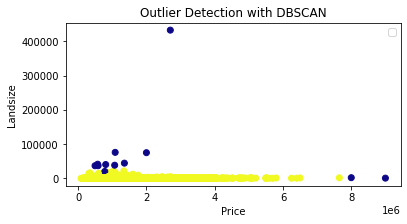

In [24]:
#A 2D Projection Of Data 
x =hdf["Price"]
y =hdf["Landsize"]

plt.figure(figsize=(6,3))
plt.scatter(x,y, c= hdf["cluster_db"], marker="o" , cmap="plasma")
plt.title("Outlier Detection with DBSCAN")
plt.xlabel("Price")
plt.ylabel("Landsize")
plt.legend()
plt.show()

<a id= "local"> </a>

### 2. Local Outlier Factor

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. Two important distinctions must be made:
- **outlier detection:** The <ins>_training data_</ins> contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations. <br>
LocalOutlierFactor does not support predict, decision_function and score_samples methods by default but only a fit_predict method. The scores of abnormality of the training samples are accessible through the negative_outlier_factor_ attribute.
- **novelty detection:** The training data is not polluted by outliers and we are interested in detecting whether a <ins>_new observation_</ins> is an outlier. In this context an outlier is also called a novelty.<br>

Instantiate the estimator with the novelty parameter set to True before fitting the estimator. In this case, fit_predict is not available. When novelty is set to True be aware that you must only use predict, decision_function and score_samples on new unseen data and not on the training samples as this would lead to wrong results. I.e., the result of predict will not be the same as fit_predict. The scores of abnormality of the training samples are always accessible through the negative_outlier_factor_ attribute. <br>

Outlier detection is then also known as unsupervised anomaly detection and novelty detection as semi-supervised anomaly detection. 

In [25]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
hdf["outlier_lof"] = clf.fit_predict(hdf[hcols])
hdf["outlier_lof"].value_counts()

 1    12222
-1     1358
Name: outlier_lof, dtype: int64

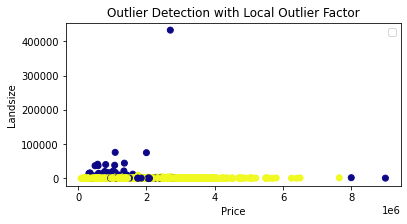

In [26]:
#A 2D Projection Of Data 
x =hdf["Price"]
y =hdf["Landsize"]

plt.figure(figsize=(6,3))
plt.scatter(x,y, c= hdf["outlier_lof"], marker="o" , cmap="plasma")
plt.title("Outlier Detection with Local Outlier Factor")
plt.xlabel("Price")
plt.ylabel("Landsize")
plt.legend()
plt.show()

How to treat Outliers:
- Remove them if they are very few
- Transform them via: Scaling, Log Transformation, Cube Root Normalization, Box-Cox Transformation
- Impute them with: Mean/Median

References:
- https://www.kaggle.com/code/kevinarvai/outlier-detection-practice-uni-multivariate/notebook
- https://www.kaggle.com/code/nareshbhat/outlier-the-silent-killer
- https://www.kaggle.com/code/gauravduttakiit/pyod-a-python-toolkit-for-outlier-detection
- https://towardsdatascience.com/anomaly-detection-with-local-outlier-factor-lof-d91e41df10f2
- https://www.kaggle.com/code/taruntiwarihp/outlier-detection-in-python-using-pyod-library